In [1]:
library(tidyverse)
library(vegan)
library(phyloseq)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: permute

Loading required package: lattice

This is vegan 2.6-5



In [2]:
setwd('/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/metadata')

In [3]:
getwd()

[1] "/project/pi_sarah_gignouxwolfsohn_uml_edu/brooke/metadata"

In [4]:
colony_data <- read.csv('CBC_ColonyData.csv')

In [5]:
head(colony_data)

,X,Date_InitialTag,Transect,TransectNum,OldTagNuim,NewTagNum,Species,Meter,Meters_90,Direction,Size_Class,Notes_June_2019,MaxDiameter,Height,Date_DocumentedDisease,Date_DocumentedMortality,Notes_May2022
,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
1,2,6/21/19,CBC30N,1,349,1,SSID,1.5,0.50,right,5,,45,24,5/21/22,Diseased,NA
2,1,6/21/19,CBC30N,1,334,2,PAST,1.4,0.10,left,4,,33,8,Healthy,Healthy,NA
3,5,6/21/19,CBC30N,1,346,3,SSID,6.3,0.80,right,5,,53,30,5/21/22,Diseased,NA
4,25,10/15/19,CBC30N,1,407,4,PSTR,6.5,0.50,right,3,,44,39,5/21/22,12/2/22,NA
5,23,6/24/19,CBC30N,1,394,5,SSID,4.3,1.20,left,5,,65,27,5/21/22,Diseased,NA
6,27,10/15/19,CBC30N,1,413,6,PSTR,8.3,1.75,left,NA,mucus_sample_taken_adjacent_to_punch,35,38,12/2/22,9/25/23,NA


In [32]:
# extract year from Date_InitialTag and add it to new column
colony_data$Year_tagged <- format(as.Date(colony_data$Date_InitialTag, format="%m/%d/%y"), "%Y")

In [ ]:
# Goal: # of colonys that died/got diseased across the years
# x-axis year
# y-axis # of colonies
# stacked bar colors: healthy, diseased, dead

In [ ]:
# 1st: create columns for each year 
# pull info from diseaseddate
# if healthy, write healthy in each column
# if date, write "diseased" in corresponding column, and "healthy" in previous years columns
# repeat for mortality 

In [ ]:
colony_data$2024HealthStatus = 
ifelse(colony_data$Date_DocumentedDisease

In [ ]:
# remember to only include colonies initally tagged in 2019 to keep numbers consistent

In [27]:
colony_data <- colony_data %>%
  mutate(
    Date_DocumentedDisease = ifelse(Date_DocumentedDisease == "Healthy", NA, as.Date(Date_DocumentedDisease, format="%m/%d/%y")),
    Date_DocumentedMortality = ifelse(Date_DocumentedMortality == "Healthy" | Date_DocumentedMortality == "Diseased", NA, as.Date(Date_DocumentedMortality, format="%m/%d/%y")),
    HealthStatus = case_when(
      is.na(Date_DocumentedDisease) & is.na(Date_DocumentedMortality) ~ "Healthy",
      !is.na(Date_DocumentedDisease) ~ "Diseased",
      !is.na(Date_DocumentedMortality) ~ "Dead"
    )
  )

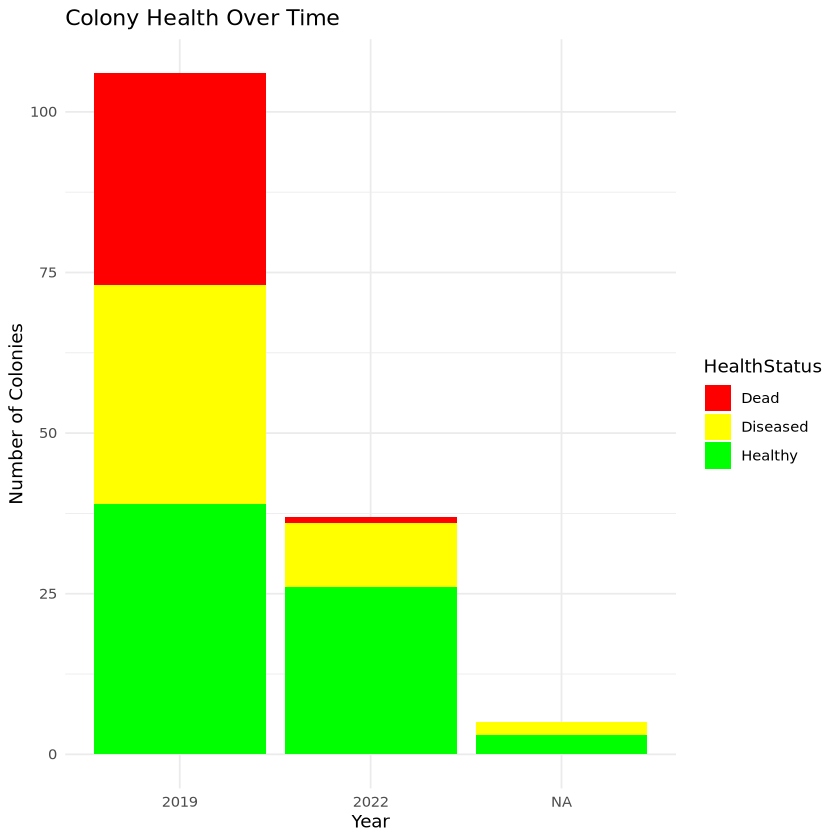

In [29]:
ggplot(colony_data, aes(x = Year, fill = HealthStatus)) +
  geom_bar(position = "stack") +
  labs(title = "Colony Health Over Time",
       x = "Year",
       y = "Number of Colonies") +
  scale_fill_manual(values = c("Healthy" = "green", "Diseased" = "yellow", "Dead" = "red")) +
  theme_minimal()